!pip install -U pip
!pip install --use-pep517 suod 
!pip install polars catboost yake threadpoolctl 
!pip install polars-splitters

### Блок загрузки

In [2]:
import polars as pl
from polars_splitters import split_into_train_eval
import polars.selectors as cs
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import select_threshold


from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest

import requests
import zipfile
import io

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import re
import gc
import yake
import nltk
from joblib import Parallel, delayed

from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
len_word = 10

RANDOM_STATE = 255

try:
    from catboost.utils import get_gpu_device_count
    gpu_count = get_gpu_device_count()
except ImportError:
    gpu_count = 0

if gpu_count > 0:
    print(f"GPU доступен, количество устройств: {gpu_count}")
    task_type = 'GPU'
else:
    print("GPU недоступен, используем CPU")
    task_type = 'CPU'

from joblib import Parallel, delayed
n_jobs = 3
custom_stopwords = {"для", "в", "с","при","вы","не","от","что","это","на","к",'<li>','</li>','</b>','<b>','<br/>'
                    'from','and','on','to','for','with','that','this','what','who'}

stop_word = stop_words.union(custom_stopwords)

chunk_size = 1000
pattern_clean = re.compile(r'[^а-яА-ЯёЁa-zA-Z0-9\s\(\)\{\}\[\]]')

GPU доступен, количество устройств: 1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rs_mi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Блок функций обработки текста и phik

In [3]:
# n - количество слов колотые проверяются top - количество оставляемых слов
def clean_text(text):
    if not isinstance(text, str):
        return ''
    cleaned = pattern_clean.sub('', text)
    return cleaned.lower().strip()

def extract_words(text, max_len=100, stop_words=None, top_k=8,n=5):
    
    if not isinstance(text, str) or not text.strip():
        return ''
    
    shortened = text if len(text) <= max_len else text[:max_len]
    
    kw_extractor = yake.KeywordExtractor(n=n,top=top_k, lan="ru", stopwords=stop_words or set())
    keywords = kw_extractor.extract_keywords(shortened)
    if not keywords:
        return ''
    return keywords[0][0]
    
def process_text_chunk(texts_chunk, stop_words=stop_word, top_k=len_word, n_jobs=-1,n=3):
    gc.collect()
    results = Parallel(n_jobs=n_jobs)(delayed(extract_words)(text, max_len=100, stop_words=stop_words, top_k=top_k,n=n) for text in texts_chunk)
    
    gc.collect()
    return results

def chunker(seq, size):
    for pos in range(0, len(seq), size):
        yield seq[pos:pos + size]



### Класс обработки текстовых и числовых даных

In [7]:
# Preprocessing pipeline
class DataPreprocessor:
    def __init__(self, col_text, col_num):
        self.col_text = col_text
        self.col_num = col_num
        self.tfidf = TfidfVectorizer(max_features=200)
        self.scaler = StandardScaler()

    def preprocess_text_columns(self, df: pl.DataFrame) -> pl.DataFrame:
        for col in self.col_text:
            print(f"Обработка столбца {col}...")
            df = df.with_columns([pl.col(col).fill_null("No "+col).cast(pl.Utf8).alias(col)])

            
            texts = df[col].to_list()
            cleaned_texts = [clean_text(t) for t in texts]
            if col=='name_rus':
                all_results = []
                for chunk in chunker(cleaned_texts, chunk_size):
                    chunk_results = process_text_chunk(chunk,top_k=5,n=5)
                    all_results.extend(chunk_results)
            elif col=='description':
                all_results = []
                for chunk in chunker(cleaned_texts, chunk_size):
                    chunk_results = process_text_chunk(chunk,top_k=5,n=5)
                    all_results.extend(chunk_results)        
            else : all_results = cleaned_texts
            
            
            df = df.with_columns([pl.Series(all_results).alias(col)])
        return df

    

    def preprocess_numeric_columns(self, df: pl.DataFrame) -> pl.DataFrame:
        for col in self.col_num:
            #print(f"Обработка столбца {col}...")
            df = df.with_columns(pl.col(col).fill_null(0).cast(pl.Int32).alias(col))    

        df = df.with_columns([
            pl.col('rating_1_count').alias('rating_1'),
            pl.col('rating_2_count').alias('rating_2'),
            pl.col('rating_3_count').alias('rating_3'),
            pl.col('rating_4_count').alias('rating_4'),
            pl.col('rating_5_count').alias('rating_5')
            ])
        df = df.with_columns([
            (pl.col('seller_time_alive') == pl.col('item_time_alive')).alias('same_time'),
            (pl.col('ItemAvailableCount') == pl.col('ItemVarietyCount')).alias('same_count')
            ])

        rating_cols = [f"rating_{i}_count" for i in range(1, 6)]
       
        def categorize(col_name):
            return (
                pl.when(pl.col(col_name) == 0).then(pl.lit("no_data"))
                    .when((pl.col(col_name) > 0) & (pl.col(col_name) <= 4)).then(pl.lit("low"))
                    .when((pl.col(col_name) > 4) & (pl.col(col_name) <= 15)).then(pl.lit("some"))
                    .otherwise(pl.lit("many"))
                    .alias(col_name)
                )    
        
        expressions = [categorize(col) for col in rating_cols]
        
        df = df.with_columns(expressions)        
        
        base_names = ["OrderAcceptedCountTotal",
                      "item_count_returns",
                      "item_count_fake_returns",
                      "item_count_sales",
                      "ExemplarReturnedCountTotal",
                      "ExemplarReturnedValueTotal",
                      "ExemplarAcceptedCountTotal",
                      "GmvTotal"]        
        suffixes = ['7', '30', '90']
        def compute_expr3(a, b, alias_name):
            return ((pl.col(b) - pl.col(a)) / (1 + pl.col(a))).alias(alias_name)

        def compute_expr4(a, b, c, alias_name):
            return pl.when((pl.col(b) != 0) & (pl.col(a) != pl.col(b))).then(
                (pl.col(a) * pl.col(c) - pl.col(b) ** 2) / (pl.col(b) ** 2 - pl.col(b) * pl.col(a))
            ).otherwise(0).alias(alias_name)

        def compute_expr(a, b, alias_name):
            return (pl.col(b) - pl.col(a) ).alias(alias_name)

        def compute_expr2(a, b, c, alias_name):
            return pl.when((pl.col(b) != 0) & (pl.col(a) != pl.col(b))).then(
                (pl.col(b) * 2 - pl.col(a) - pl.col(c) ) / (pl.col(b)  -  pl.col(a))
            ).otherwise(0).alias(alias_name)            
        
        expressions = []

        for base in base_names:
            a = base + suffixes[0]
            b = base + suffixes[1]
            c = base + suffixes[2]
            
            expressions.append(compute_expr(a, b, alias_name = f'{base}_{suffixes[0]}_{suffixes[1]}_dt'))
            expressions.append(compute_expr(b, c, alias_name = f'{base}_{suffixes[1]}_{suffixes[2]}_dt'))
            expressions.append(compute_expr2(a, b, c, alias_name = f'{base}_diff'))
            expressions.append(compute_expr3(a, b, alias_name = f'{base}_{suffixes[0]}_{suffixes[1]}_d_n'))
            expressions.append(compute_expr3(b, c, alias_name = f'{base}_{suffixes[1]}_{suffixes[2]}_d_n'))
            expressions.append(compute_expr4(a, b, c, alias_name = f'{base}_diff2'))
        
        # Добавляем дополнительное выражение по ItemVarietyCount и ItemAvailableCount
        expressions.append(
            ((pl.col('ItemVarietyCount') - pl.col('ItemAvailableCount')) / (1 + pl.col('ItemAvailableCount'))).alias('Delta_Count')
        )
        
        # Добавляем вычисляемые столбцы
        df = df.with_columns(expressions)
        
        # Удаляем исходные родительские столбцы
        columns_to_drop = [base + suf for base in base_names for suf in suffixes]
        #df = df.drop(columns_to_drop)
       
        return df

    
        
    

### Класс обработки CBLOF и iforest

In [8]:
# CBLOF anomaly detection feature
class CBLOFAdder:
    def __init__(self, contamination=0.1, n_clusters=3, alpha=0.9, beta=5, tfidf_max_features=100):
        
        self.cblof = CBLOF(contamination=contamination, n_clusters=n_clusters, alpha=alpha, beta=beta)
        self.cblof2 = CBLOF(contamination=contamination, n_clusters=n_clusters, alpha=alpha, beta=beta)
        self.tfidf = TfidfVectorizer(max_features=tfidf_max_features)
        self.iforest = IForest(contamination=contamination, random_state=RANDOM_STATE)
        self.iforest2 = IForest(contamination=contamination, random_state=RANDOM_STATE)
        

    def add_cblof_feature(self, df: pd.DataFrame, numeric_cols, text_cols, fit_cblof=True,typelof='CBLOF',type_text =True):
        print(f"Обработка столбца {typelof}...")
        X_full = df[numeric_cols].values
        #print('cblof_ numeric_cols',numeric_cols)
        #print('cblof_ text_cols',text_cols)
        
        if type_text:
            for col in text_cols:
                text_features = self.tfidf.fit_transform(df[col]).toarray() if fit_cblof else self.tfidf.transform(df[col]).toarray()
                X_full = np.hstack([X_full, text_features])
            if fit_cblof:
                if typelof=='CBLOF':
                    self.cblof.fit(X_full)
                else :
                    self.iforest.fit(X_full)
            if typelof=='CBLOF':
                anom_preds = self.cblof.predict(X_full)  # 0 - normal, 1 - anomaly
            else : anom_preds = self.iforest.predict(X_full)
        else:
            if fit_cblof:
                if typelof=='CBLOF':
                    self.cblof2.fit(X_full)
                else :
                    self.iforest2.fit(X_full)
            if typelof=='CBLOF':
                anom_preds = self.cblof2.predict(X_full)  # 0 - normal, 1 - anomaly
            else : anom_preds = self.iforest2.predict(X_full)


            
        return anom_preds.reshape(-1,1)

### Класс Catboost 

In [66]:
class CatBoostPipeline:
    def __init__(self, text_features, cat_features, params, random_state=RANDOM_STATE, n_splits=5):
        self.text_features = text_features
        self.cat_features =  cat_features
        self.params = params
        self.random_state = random_state
        self.n_splits = n_splits
        self.best_model = None
        self.best_score = -np.inf
        self.best_params = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        for params in ParameterGrid(self.params):
            f1_scores = []
            current_best_model = None
            current_best_score = -np.inf
            for train_idx, valid_idx in skf.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

                train_pool = Pool(X_train, y_train, text_features=self.text_features,cat_features=self.cat_features)
                valid_pool = Pool(X_valid, y_valid, text_features=self.text_features,cat_features=self.cat_features)

                model = CatBoostClassifier(**params, text_features=self.text_features,cat_features=self.cat_features)#,class_weights=[1, 14])
                model.fit(train_pool, eval_set=valid_pool, verbose=False, early_stopping_rounds=10)
                #model.set_probability_threshold(0.45059490126123963)#смещение поррога
                
                preds = model.predict(valid_pool)
                f1 = f1_score(y_valid, preds, average='macro')
                f1_scores.append(f1)

                if f1 > current_best_score:
                    current_best_score = f1
                    current_best_model = model

                del train_pool, valid_pool
                gc.collect()

            mean_f1 = np.mean(f1_scores)
            print(f"Params: {params} -> Mean F1: {mean_f1:.4f}")
            if mean_f1 > self.best_score:
                self.best_score = mean_f1
                self.best_params = params
                self.best_model = current_best_model
        return self.best_model

    def predict(self, X: pd.DataFrame):
        if self.best_model is None:
            raise ValueError("Model is not trained yet.")
        #self.best_model.set_probability_threshold(0.9145914174559909)    
        return self.best_model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        if self.best_model is None:
            raise ValueError("Model is not trained yet.")
        return self.best_model.predict_proba(X)

### Обработка X train

In [1]:
train_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_train.csv'
test_path = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_test.csv'
app_test = 'ml_ozon_сounterfeit_new_test.csv'
target='resolution'
col_drop=['id','ItemID','SellerID','comments_published_count','photos_published_count','videos_published_count']
text_cols = ['name_rus','CommercialTypeName4','brand_name','description']
    # Загрузка данных
    
    #del  df_train,df_test,df_train_pd,df_test_pd,X_test,X_train
gc.collect()
df_train = pl.read_csv(train_path)
df_test_old = pl.read_csv(test_path)
df_test_append = pl.read_csv(app_test)

df_test = df_test_old.vstack(df_test_append)
del df_test_old,df_test_append
#df_train = df_train.head(500)
#df_test = df_test.head(100)

# Определение числовых колонок без дропа

num_cols = [col for col, dtype in df_train.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
col_num = list(set(num_cols) - set(col_drop)-set(target))
# Инициализация предобработчика
preprocessor = DataPreprocessor(col_text=text_cols, col_num=col_num)
# Предобработка train
df_train = preprocessor.preprocess_text_columns(df_train)
df_train = preprocessor.preprocess_numeric_columns(df_train)
df_train_pd = df_train.to_pandas()
del df_train
# Масштабирование числовых признаков включая cblof
noscaler = ['rating_1','rating_2','rating_3','rating_4','rating_5']
col_num2 = df_train_pd.drop(columns=([target] + col_drop + noscaler)).select_dtypes(include=[np.number]).columns.tolist()
scaler_cols = [col for col in col_num2 if col != 'resolution']
df_train_pd[scaler_cols] = preprocessor.scaler.fit_transform(df_train_pd[scaler_cols])


# Добавляем признак аномалии CBLOF

n_clusters = 4
cblof_adder = CBLOFAdder(contamination=0.1, n_clusters=n_clusters, alpha=0.9, beta=5)    

df_train_pd['cblof_text'] = cblof_adder.add_cblof_feature(df_train_pd, numeric_cols=scaler_cols,
                                                          text_cols=text_cols, fit_cblof=True,typelof='CBLOF',type_text =True)
df_train_pd['iforest_text'] = cblof_adder.add_cblof_feature(df_train_pd, numeric_cols=scaler_cols,
                                                            text_cols=text_cols, fit_cblof=True,typelof='iforest',type_text =True)
df_train_pd['cblof'] = cblof_adder.add_cblof_feature(df_train_pd.drop(columns=text_cols),numeric_cols=scaler_cols,
                                                     text_cols=[], fit_cblof=True,typelof='CBLOF',type_text =False)
df_train_pd['iforest'] = cblof_adder.add_cblof_feature(df_train_pd.drop(columns=text_cols),numeric_cols=scaler_cols,
                                                       text_cols=[], fit_cblof=True,typelof='iforest',type_text =False)


# Разбиваем на признаки и таргет
#f_train_pd.to_csv('df_train_pd.csv', index=False)
cat_cols = ['cblof','cblof_text',
            'iforest','same_time','iforest_text',
            'rating_1_count','rating_2_count','rating_3_count','rating_4_count','rating_5_count',
            'rating_1','rating_2','rating_3','rating_4','rating_5',]

print(df_train_pd.loc[0,'description'])
print(df_train_pd.loc[0,'name_rus'])

X_train = df_train_pd.drop(columns=[target]+col_drop).copy()#[main_feature]
y_train = df_train_pd[target]
del df_train_pd


NameError: name 'gc' is not defined

In [2]:
X_all = X_train.copy()

NameError: name 'X_train' is not defined

In [ ]:
0                             brand_name   20.417295
3                    CommercialTypeName4   13.938858
2                               name_rus    9.731169
10                       item_time_alive    7.849045
1                            description    7.459299
9                        PriceDiscounted    5.921090
35                      ItemVarietyCount    3.484067
22                            GmvTotal90    3.211667
36                    ItemAvailableCount    2.572409
20                             GmvTotal7    2.008931
8                         rating_5_count    1.577918
91                    GmvTotal_30_90_d_n    1.326972
70   ExemplarReturnedCountTotal_30_90_dt    1.164810
90                     GmvTotal_7_30_d_n    1.114871
85  ExemplarAcceptedCountTotal_30_90_d_n    1.015808
37                     seller_time_alive    1.014566
88                     GmvTotal_30_90_dt    0.920570
21                            GmvTotal30    0.902836
27             OrderAcceptedCountTotal30    0.851813
26              OrderAcceptedCountTotal7    0.801358

In [44]:
main_feature = ['brand_name','CommercialTypeName4',
                'description', 'name_rus',
                'item_time_alive','seller_time_alive',
                'PriceDiscounted','ItemVarietyCount','ItemAvailableCount',
                #'rating_5_count',
                'GmvTotal30', 'GmvTotal90', 'GmvTotal_30_90_d_n','GmvTotal_7_30_d_n','GmvTotal_30_90_dt', #'GmvTotal7',
                'ExemplarReturnedCountTotal_30_90_dt','ExemplarAcceptedCountTotal_30_90_d_n',                
                'OrderAcceptedCountTotal30','OrderAcceptedCountTotal7'
                ]

In [54]:
cat_cols = ['cblof','cblof_text',
            'iforest','same_time','iforest_text',
            'rating_1_count','rating_2_count','rating_3_count','rating_4_count','rating_5_count',
            'rating_1','rating_2','rating_3','rating_4','rating_5',]
X_train = X_all

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197198 entries, 0 to 197197
Data columns (total 98 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   brand_name                            197198 non-null  object 
 1   description                           197198 non-null  object 
 2   name_rus                              197198 non-null  object 
 3   CommercialTypeName4                   197198 non-null  object 
 4   rating_1_count                        197198 non-null  object 
 5   rating_2_count                        197198 non-null  object 
 6   rating_3_count                        197198 non-null  object 
 7   rating_4_count                        197198 non-null  object 
 8   rating_5_count                        197198 non-null  object 
 9   PriceDiscounted                       197198 non-null  float64
 10  item_time_alive                       197198 non-null  float64
 11  

### Catboost

Params: {'allow_writing_files': False, 'custom_metric': 'Recall', 'depth': 12, 'early_stopping_rounds': 3, 'eval_metric': 'F1', 'gpu_ram_part': 0.8, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'loss_function': 'Logloss', 'random_seed': 255, 'task_type': 'GPU', 'thread_count': 3, 'use_best_model': True, 'used_ram_limit': '12gb', 'verbose': 1} -> Mean F1: 0.8897
Отчёт по обучающей выборке:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    184146
           1       0.87      0.83      0.85     13052

    accuracy                           0.98    197198
   macro avg       0.93      0.91      0.92    197198
weighted avg       0.98      0.98      0.98    197198



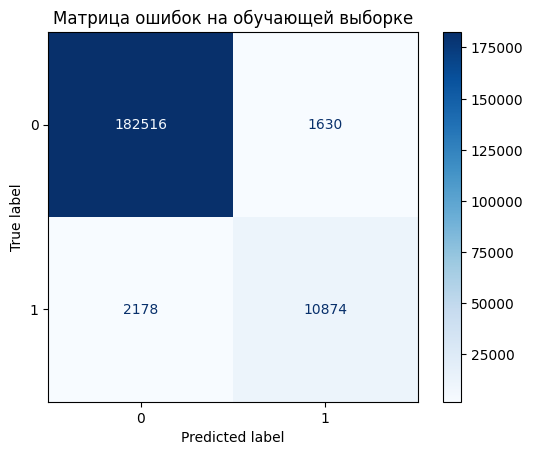

Confusion Matrix:
[[182516   1630]
 [  2178  10874]]
Top 20 most important features:
                                feature  importance
0                            brand_name   16.142774
3                   CommercialTypeName4   13.680364
2                              name_rus   10.478522
1                           description    7.176461
10                      item_time_alive    6.885231
9                       PriceDiscounted    5.482553
35                     ItemVarietyCount    5.024734
37                    seller_time_alive    4.178693
36                   ItemAvailableCount    2.915998
21                           GmvTotal30    2.113262
8                        rating_5_count    1.818674
22                           GmvTotal90    1.779464
87                     GmvTotal_7_30_dt    1.305569
70  ExemplarReturnedCountTotal_30_90_dt    1.189836
90                    GmvTotal_7_30_d_n    1.120458
31         ExemplarReturnedCountTotal90    1.038546
26             OrderAcceptedCou

In [65]:
text_feature_indices = [X_train.columns.get_loc(c) for c in text_cols if c in X_train.columns]
cat_features = [X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns]
# Настройки модели
param_grid = {        
        'depth': [12],
        'learning_rate': [0.1],
        'l2_leaf_reg': [1],
        'iterations': [400],
        'task_type': [task_type],
        'gpu_ram_part': [0.8],
        'loss_function': ['Logloss'],
        #'custom_loss': ['AUC'],
        'eval_metric': ['F1'],
        'custom_metric':['Recall'],
        'random_seed': [RANDOM_STATE],
        'early_stopping_rounds': [3],
        #'auto_class_weights':['Balanced'],
        'use_best_model': [True],
        'verbose': [1],
        'thread_count': [3],
        'allow_writing_files':[False],
        'used_ram_limit': ['12gb']
        }



# Обучение CatBoost с кроссвалидацией
cb_pipeline = CatBoostPipeline(text_features=text_feature_indices, cat_features = cat_features,params=param_grid)
best_model = cb_pipeline.fit(X_train, y_train)
# Отчёт по модели на train
train_preds = cb_pipeline.predict(X_train)
print("Отчёт по обучающей выборке:")
print(classification_report(y_train, train_preds))
ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train, cmap=plt.cm.Blues)
plt.title("Матрица ошибок на обучающей выборке")
plt.show()

cm = confusion_matrix(y_train, train_preds)
print("Confusion Matrix:")
print(cm)

feature_importances = best_model.get_feature_importance()

# Получить имена признаков, если X_test — pandas DataFrame
feature_names = X_train.columns

# Создать DataFrame с важностями
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Отсортировать по убыванию важности и взять топ-20
top_20 = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

print("Top 20 most important features:")
print(top_20)

In [63]:
from catboost.utils import select_threshold
from catboost import Pool
eval_pool = Pool(X_train, y_train,text_features=text_feature_indices, cat_features = cat_features)
opt_threshold = select_threshold(model=best_model, data=eval_pool, FPR=0.01)
print("Оптимальный порог для FPR=0.01:", opt_threshold)

Оптимальный порог для FPR=0.01: 0.45059490126123963


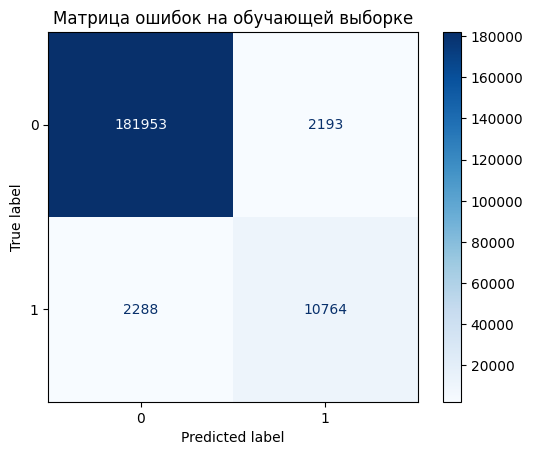

In [14]:
# n 5 0.5
ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train, cmap=plt.cm.Blues)
plt.title("Матрица ошибок на обучающей выборке")
plt.savefig('confusion_matrix.png')

### Обработка test

In [ ]:
# Предобработка тестовых данных
df_test = preprocessor.preprocess_text_columns(df_test)
#Результаты на тестовых данных
num_cols = [col for col, dtype in df_test.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
#col_num = list(set(num_cols) - set(col_drop))
col_num.remove('resolution')
df_test = preprocessor.preprocess_numeric_columns(df_test)

df_test_pd = df_test.to_pandas()
del df_test
#print('test num col ',df_test_pd.select_dtypes(include=[np.number]).columns.tolist())
#print('test scaler_col  ', scaler_cols)
df_test_pd[scaler_cols] = preprocessor.scaler.transform(df_test_pd[scaler_cols])

# Добавляем признак аномалии CBLOF для теста (без повторного обучения)    

df_test_pd['cblof'] = cblof_adder.add_cblof_feature(df_test_pd, 
                                                    numeric_cols=scaler_cols, text_cols=[], fit_cblof=False,typelof='CBLOF',type_text =False)
df_test_pd['cblof_text'] = cblof_adder.add_cblof_feature(df_test_pd, numeric_cols=scaler_cols,
                                                         text_cols=text_cols, fit_cblof=False,typelof='CBLOF')
df_test_pd['iforest_text'] = cblof_adder.add_cblof_feature(df_test_pd, numeric_cols=scaler_cols, 
                                                            text_cols=text_cols, fit_cblof=False,typelof='iforest',type_text =True)
df_test_pd['iforest'] = cblof_adder.add_cblof_feature(df_test_pd, numeric_cols=scaler_cols, 
                                                      text_cols=[], fit_cblof=False,typelof='iforest',type_text =False)

df_test_pd[text_cols] = df_test_pd[text_cols].astype('string')

# Подготовка теста для предсказаний
X_test = df_test_pd.drop(columns=col_drop).copy() #[main_feature]
X_test.info()

In [ ]:
X_test_all = X_test.copy()
X_test = X_test_all

In [60]:
id_test = df_test_pd['id']
#del df_test_pd
# Предсказания и сохранение результата
#cb_pipeline.set_probability_threshold(0.9228)
predictions = cb_pipeline.predict(X_test)
submission = pd.DataFrame({
    'id': id_test, #if 'id' in df_test_pd.columns else range(len(df_test_pd)),
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)
print("Сохранён файл submission.csv с предсказаниями")

Сохранён файл submission.csv с предсказаниями


### Основной pipeline 

In [15]:
def main_pipeline(train_path, test_path, app_test,target='resolution', col_drop=['id','ItemID','SellerID','comments_published_count',
                                                                        'photos_published_count','videos_published_count'
                                                                       ],
                  text_cols = ['name_rus','CommercialTypeName4','brand_name','description']):
    # Загрузка данных
    
    #del  df_train,df_test,df_train_pd,df_test_pd,X_test,X_train
    gc.collect()
    df_train = pl.read_csv(train_path)
    df_test_old = pl.read_csv(test_path)
    df_test_append = pl.read_csv(app_test)
    
    df_test = df_test_old.vstack(df_test_append)
    del df_test_old,df_test_append

    #df_train = df_train.head(500)
    #df_test = df_test.head(100)

    
    # Определение числовых колонок без дропа
    
    num_cols = [col for col, dtype in df_train.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
    col_num = list(set(num_cols) - set(col_drop)-set(target))

    # Инициализация предобработчика
    preprocessor = DataPreprocessor(col_text=text_cols, col_num=col_num)

    # Предобработка train
    df_train = preprocessor.preprocess_text_columns(df_train)
    df_train = preprocessor.preprocess_numeric_columns(df_train)
    df_train_pd = df_train.to_pandas()
    del df_train
    # Масштабирование числовых признаков включая cblof
    noscaler = ['rating_1','rating_2','rating_3','rating_4','rating_5']
    col_num2 = df_train_pd.drop(columns=([target] + col_drop + noscaler)).select_dtypes(include=[np.number]).columns.tolist()
    scaler_cols = [col for col in col_num2 if col != 'resolution']

    df_train_pd[scaler_cols] = preprocessor.scaler.fit_transform(df_train_pd[scaler_cols])
    
    
    # Добавляем признак аномалии CBLOF
    
    n_clusters = 4
    cblof_adder = CBLOFAdder(contamination=0.1, n_clusters=n_clusters, alpha=0.9, beta=5)    
    
    df_train_pd['cblof_text'] = cblof_adder.add_cblof_feature(df_train_pd, numeric_cols=scaler_cols,
                                                             text_cols=text_cols, fit_cblof=True,typelof='CBLOF',type_text =True)
    df_train_pd['iforest_text'] = cblof_adder.add_cblof_feature(df_train_pd, numeric_cols=scaler_cols, 
                                                                text_cols=text_cols, fit_cblof=True,typelof='iforest',type_text =True)
    df_train_pd['cblof'] = cblof_adder.add_cblof_feature(df_train_pd.drop(columns=text_cols), 
                                                         numeric_cols=scaler_cols, text_cols=[], fit_cblof=True,typelof='CBLOF',type_text =False)
    df_train_pd['iforest'] = cblof_adder.add_cblof_feature(df_train_pd.drop(columns=text_cols), 
                                                           numeric_cols=scaler_cols, text_cols=[], fit_cblof=True,typelof='iforest',type_text =False)
    
   
    # Разбиваем на признаки и таргет
    #df_train_pd.to_csv('df_phik.csv', index=False)
    cat_cols = ['cblof','cblof_text','iforest','same_time','iforest_text',
                'rating_1_count','rating_2_count','rating_3_count','rating_4_count','rating_5_count',
                'rating_1','rating_2','rating_3','rating_4','rating_5',
               ]
   
    df_train_pd[cat_cols].info()
    print(df_train_pd.isnull().sum())
    X_train = df_train_pd.drop(columns=[target]+col_drop).copy()#[main_feature]
    y_train = df_train_pd[target]
    del df_train_pd
    print(X_train.head())
    text_feature_indices = [X_train.columns.get_loc(c) for c in text_cols if c in X_train.columns]
    cat_features = [X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns]

    # Настройки модели
    param_grid = {        
            'depth': [12],
            'learning_rate': [0.1],
            'l2_leaf_reg': [1],
            'iterations': [400],
            'task_type': [task_type],
            'gpu_ram_part': [0.8],
            'loss_function': ['Logloss'],
            #'custom_loss': ['AUC'],
            'eval_metric': ['F1'],
            'custom_metric':['Recall'],
            'random_seed': [RANDOM_STATE],
            'early_stopping_rounds': [5],
            'use_best_model': [True],
            'verbose': [1],
            'thread_count': [3],
            'allow_writing_files':[False],
            'used_ram_limit': ['12gb']
            }

    # Обучение CatBoost с кроссвалидацией
    cb_pipeline = CatBoostPipeline(text_features=text_feature_indices, cat_features = cat_features,params=param_grid)
    best_model = cb_pipeline.fit(X_train, y_train)
    cm = confusion_matrix(y_train, train_preds)
    print("Confusion Matrix:")
    print(cm)

    feat_imp_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.get_feature_importance()
        })

    top_20 = feat_imp_df.sort_values(by='importance', ascending=False).head(20)
    print("Top 20 most important features:")
    print(top_20)

    # Отчёт по модели на train
    train_preds = cb_pipeline.predict(X_train)
    print("Отчёт по обучающей выборке:")
    print(classification_report(y_train, train_preds))
    ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train, cmap=plt.cm.Blues)
    plt.title("Матрица ошибок на обучающей выборке")
    plt.savefig('confusion_matrix.png')
    plt.show()
    cm = confusion_matrix(y_train, train_preds)
    print("Confusion Matrix:")
    print(cm)

    

### Результаты на тестовых данных
    # Предобработка тестовых данных
    df_test = preprocessor.preprocess_text_columns(df_test)

    num_cols = [col for col, dtype in df_test.schema.items() if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64]]
    #col_num = list(set(num_cols) - set(col_drop))
    col_num.remove('resolution')
    df_test = preprocessor.preprocess_numeric_columns(df_test)
    
    df_test_pd = df_test.to_pandas()
    del df_test
    #print('test num col ',df_test_pd.select_dtypes(include=[np.number]).columns.tolist())
    #print('test scaler_col  ', scaler_cols)

    df_test_pd[scaler_cols] = preprocessor.scaler.transform(df_test_pd[scaler_cols])
    
    # Добавляем признак аномалии CBLOF для теста (без повторного обучения)    
    
    df_test_pd['cblof'] = cblof_adder.add_cblof_feature(df_test_pd, 
                                                        numeric_cols=scaler_cols, text_cols=[], fit_cblof=False,typelof='CBLOF',type_text =False)
    df_test_pd['cblof_text'] = cblof_adder.add_cblof_feature(df_test_pd, numeric_cols=scaler_cols,
                                                             text_cols=text_cols, fit_cblof=False,typelof='CBLOF')
    df_test_pd['iforest_text'] = cblof_adder.add_cblof_feature(df_test_pd, numeric_cols=scaler_cols, 
                                                                text_cols=text_cols, fit_cblof=False,typelof='iforest',type_text =True)
    df_test_pd['iforest'] = cblof_adder.add_cblof_feature(df_test_pd, numeric_cols=scaler_cols, 
                                                          text_cols=[], fit_cblof=False,typelof='iforest',type_text =False)
    
    df_test_pd[text_cols] = df_test_pd[text_cols].astype('string')
    

    # Подготовка теста для предсказаний
    X_test = df_test_pd.drop(columns=col_drop).copy() #[main_feature]
    X_test.info()
    
    id_test = df_test_pd['id']
    del df_test_pd
    # Предсказания и сохранение результата
    predictions = cb_pipeline.predict(X_test)
    submission = pd.DataFrame({
        'id': id_test, #if 'id' in df_test_pd.columns else range(len(df_test_pd)),
        'prediction': predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Сохранён файл submission.csv с предсказаниями")

    
   

### Запуск

Обработка столбца name_rus...
Обработка столбца CommercialTypeName4...
Обработка столбца brand_name...
Обработка столбца description...
Обработка столбца CBLOF...
Обработка столбца iforest...
Обработка столбца CBLOF...
Обработка столбца iforest...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197198 entries, 0 to 197197
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   cblof           197198 non-null  int64 
 1   cblof_text      197198 non-null  int64 
 2   iforest         197198 non-null  int64 
 3   same_time       197198 non-null  bool  
 4   iforest_text    197198 non-null  int64 
 5   rating_1_count  197198 non-null  object
 6   rating_2_count  197198 non-null  object
 7   rating_3_count  197198 non-null  object
 8   rating_4_count  197198 non-null  object
 9   rating_5_count  197198 non-null  object
 10  rating_1        197198 non-null  int32 
 11  rating_2        197198 non-null  int32 
 12  rating

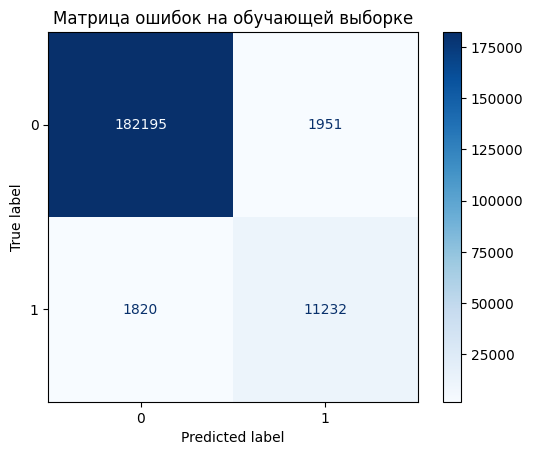

In [7]:
path_to_train = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_train.csv'
path_to_test = 'OZON/ml_ozon_сounterfeit_data/ml_ozon_сounterfeit_test.csv'
app_test = 'ml_ozon_сounterfeit_new_test.csv'
url = "https://storage.codenrock.com/public/companies/codenrock-13/ml_ozon_сounterfeit_train_images.zip?response-content-disposition=attachment%3B+filename%3D%22ml_ozon_%D1%81ounterfeit_train_images.zip%22"

main_pipeline(path_to_train, path_to_test,app_test)